# Feature Map Variance

We measure feature map variance to demonstrate that ***MSAs aggregate feature maps and Convs (and MLPs) diversify them*** as shown in Fig 9 and Fig D.1.

In [1]:
import sys

# check whether run in Colab
root = "."
if "google.colab" in sys.modules:
    print("Running in Colab.")
    !pip3 install matplotlib
    !pip3 install einops==0.4.1
    !pip3 install timm==0.5.4
    !git clone https://github.com/xxxnell/how-do-vits-work.git
    root = "./how-do-vits-work"
    sys.path.append(root)

In [2]:
import yaml
import copy

import torch
from torch.utils.data import DataLoader

import models
import ops.tests as tests
import ops.datasets as datasets

ModuleNotFoundError: No module named 'yaml'

In [ ]:
# config_path = "%s/configs/cifar10_vit.yaml" % root
config_path = "%s/configs/cifar100_vit.yaml" % root
# config_path = "%s/configs/imagenet_vit.yaml" % root

with open(config_path) as f:
    args = yaml.load(f)
    print(args)

{'dataset': {'name': 'cifar100', 'root': '../data', 'mean': [0.5071, 0.4867, 0.4408], 'std': [0.2675, 0.2565, 0.2761], 'padding': 4, 'color_jitter': 0.0, 'auto_augment': 'rand-m9-n2-mstd1.0', 're_prob': 0.0}, 'train': {'warmup_epochs': 5, 'epochs': 300, 'batch_size': 96, 'max_norm': 5, 'smoothing': 0.1, 'mixup': {'num_classes': 100, 'mixup_alpha': 1.0, 'cutmix_alpha': 0.8, 'prob': 1.0}}, 'val': {'batch_size': 256, 'n_ff': 1}, 'model': {'stem': False, 'block': {'image_size': 32, 'patch_size': 2, 'sd': 0.1}}, 'optim': {'name': 'AdamW', 'lr': 0.000125, 'weight_decay': 0.05, 'scheduler': {'name': 'CosineAnnealingLR', 'T_max': 300, 'eta_min': 0}}, 'env': {}}


In [ ]:
dataset_args = copy.deepcopy(args).get("dataset")
train_args = copy.deepcopy(args).get("train")
val_args = copy.deepcopy(args).get("val")
model_args = copy.deepcopy(args).get("model")
optim_args = copy.deepcopy(args).get("optim")
env_args = copy.deepcopy(args).get("env")

In [ ]:
dataset_train, dataset_test = datasets.get_dataset(**dataset_args, download=True)
dataset_name = dataset_args["name"]
num_classes = len(dataset_train.classes)

dataset_train = DataLoader(
    dataset_train, 
    shuffle=True, 
    num_workers=train_args.get("num_workers", 4), 
    batch_size=train_args.get("batch_size", 128),
)
dataset_test = DataLoader(
    dataset_test, 
    num_workers=val_args.get("num_workers", 4), 
    batch_size=val_args.get("batch_size", 32),
)

print("Train: %s, Test: %s, Classes: %s" % (
    len(dataset_train.dataset), 
    len(dataset_test.dataset), 
    num_classes
))

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ../data/cifar-100-python.tar.gz to ../data
Files already downloaded and verified
Train: 50000, Test: 10000, Classes: 100


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Load and Prepare Pretrained Models

Divide the pretrained models into the sequences of blocks (the cells below provide the snippets for ResNet-50 and ViT-Ti):

In [ ]:
# download and load a pretrained model for CIFAR-100
url = "https://github.com/xxxnell/how-do-vits-work-storage/releases/download/v0.1/resnet_50_cifar100_691cc9a9e4.pth.tar"
path = "checkpoints/resnet_50_cifar100_691cc9a9e4.pth.tar"
models.download(url=url, path=path)

name = "resnet_50"
model = models.get_model(name, num_classes=num_classes,  # timm does not provide a ResNet for CIFAR
                         stem=model_args.get("stem", False))
map_location = "cuda" if torch.cuda.is_available() else "cpu"
checkpoint = torch.load(path, map_location=map_location)
model.load_state_dict(checkpoint["state_dict"])

# model → blocks. `blocks` is a sequence of blocks
blocks = [
    model.layer0,
    *model.layer1,
    *model.layer2,
    *model.layer3,
    *model.layer4,
    model.classifier,
]

100%|██████████| 285M/285M [00:10<00:00, 27.3MiB/s]


model: resnet_50 , params: 23.7M, output: [3, 100]


In [ ]:
import copy
import timm
import torch
import torch.nn as nn

# download and load a pretrained model for CIFAR-100
url = "https://github.com/xxxnell/how-do-vits-work-storage/releases/download/v0.1/vit_ti_cifar100_9857b21357.pth.tar"
path = "checkpoints/vit_ti_cifar100_9857b21357.pth.tar"
models.download(url=url, path=path)

model = timm.models.vision_transformer.VisionTransformer(
    num_classes=100, img_size=32, patch_size=2,  # for CIFAR
    embed_dim=192, depth=12, num_heads=3, qkv_bias=False,  # for ViT-Ti 
)
model.name = "vit_ti"
models.stats(model)
map_location = "cuda" if torch.cuda.is_available() else "cpu"
checkpoint = torch.load(path, map_location=map_location)
model.load_state_dict(checkpoint["state_dict"])


# model → blocks. `blocks` is a sequence of blocks

class PatchEmbed(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = copy.deepcopy(model)
        
    def forward(self, x, **kwargs):
        x = self.model.patch_embed(x)
        cls_token = self.model.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = self.model.pos_drop(x + self.model.pos_embed)
        return x
    
class Residual(nn.Module):
    def __init__(self, *fn):
        super().__init__()
        self.fn = nn.Sequential(*fn)
        
    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x
    
    
class Lambda(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
    def forward(self, x):
        return self.fn(x)


def flatten(xs_list):
    return [x for xs in xs_list for x in xs]


# model → blocks. `blocks` is a sequence of blocks
blocks = [
    PatchEmbed(model),
    *flatten([[Residual(b.norm1, b.attn), Residual(b.norm2, b.mlp)] 
              for b in model.blocks]),
    nn.Sequential(model.norm, Lambda(lambda x: x[:, 0]), model.head),
]

100%|██████████| 65.0M/65.0M [00:01<00:00, 50.7MiB/s]


model: vit_ti , params: 5.4M


## Plot Feature Map Variances

In [ ]:
xs, ys = next(iter(dataset_test))  # only one batch is used for simplicity

# accumulate `latents` by collecting hidden states of a model
latents = []
with torch.no_grad():
    for block in blocks:
        xs = block(xs)
        latents.append(xs)
        
if model.name in ["vit_ti", "pit_ti"]:  # for ViT: Drop CLS token
    latents = [latent[:,1:] for latent in latents]
latents = latents[:-1]  # drop logit (output)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


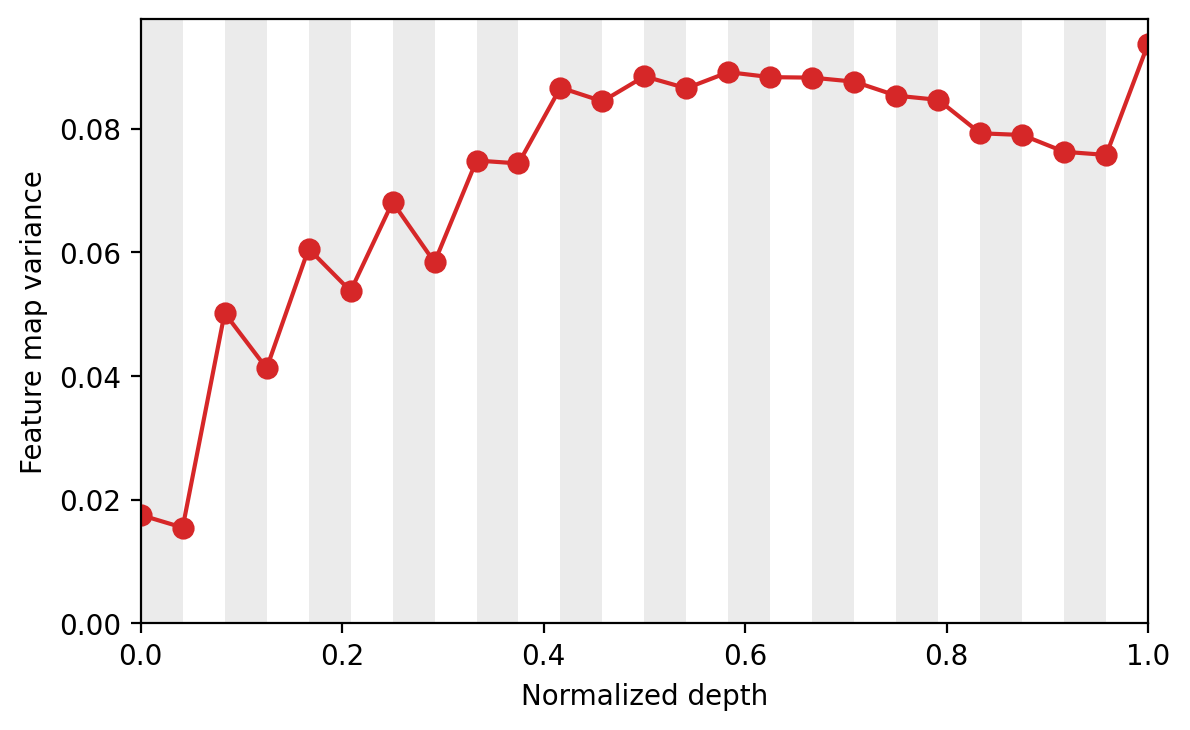

In [ ]:
import math
from einops import rearrange, reduce, repeat


# aggregate feature map variances
variances = []
for latent in latents:  # `latents` is a list of hidden feature maps in latent spaces
    latent = latent.cpu()
    
    if len(latent.shape) == 3:  # for ViT
        b, n, c = latent.shape
        h, w = int(math.sqrt(n)), int(math.sqrt(n))
        latent = rearrange(latent, "b (h w) c -> b c h w", h=h, w=w)
    elif len(latent.shape) == 4:  # for CNN
        b, c, h, w = latent.shape
    else:
        raise Exception("shape: %s" % str(latent.shape))
                
    variances.append(latent.var(dim=[-1, -2]).mean(dim=[0, 1]))
    

# Plot Fig 9: "Feature map variance"
import numpy as np
import matplotlib.pyplot as plt

if model.name == "resnet_50":  # for ResNet-50
    pools = [4, 8, 14]
    msas = []
    marker = "D"
    color = "tab:blue"
elif model.name == "vit_ti":  # for ViT-Ti
    pools = []
    msas = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23,]
    marker = "o"
    color = "tab:red"
else:
    import warnings
    warnings.warn("The configuration for %s are not implemented." % model.name, Warning)
    pools, msas = [], []
    marker = "s"
    color = "tab:green"

depths = range(len(variances))

# normalize
depth = len(depths) - 1
depths = (np.array(depths)) / depth
pools = (np.array(pools)) / depth
msas = (np.array(msas)) / depth


fig, ax = plt.subplots(1, 1, figsize=(6.5, 4), dpi=200)
ax.plot(depths, variances, marker=marker, color=color, markersize=7)

for pool in pools:
    ax.axvspan(pool - 1.0 / depth, pool + 0.0 / depth, color="tab:blue", alpha=0.15, lw=0)
for msa in msas:
    ax.axvspan(msa - 1.0 / depth, msa + 0.0 / depth, color="tab:gray", alpha=0.15, lw=0)
    
ax.set_xlim(left=0, right=1.0)
ax.set_ylim(bottom=0.0,)

ax.set_xlabel("Normalized depth")
ax.set_ylabel("Feature map variance")

plt.show()